**Here we import all libraries needed**



In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from tensorflow.keras.preprocessing.text import Tokenizer

**Here we connect our program to google disc and load input data from it**

In [2]:
# Mount Google Drive if using datasets stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set file paths (modify these paths based on where your files are stored)
train_path = '/content/drive/MyDrive/deep_learning_project/data/train'  # Adjust to the correct path
valid_path = '/content/drive/MyDrive/deep_learning_project/data/validation'  # Adjust to the correct path
test_path = '/content/drive/MyDrive/deep_learning_project/data/test'  # Adjust to the correct path

In [4]:
# Load the train dataset
df_train_history = pd.read_parquet(os.path.join(train_path, 'history.parquet'))
df_train_behaviors = pd.read_parquet(os.path.join(train_path, 'behaviors.parquet'))
df_train_articles = pd.read_parquet(os.path.join(train_path, 'articles.parquet'))

# Load the validation dataset
df_valid_history = pd.read_parquet(os.path.join(valid_path, 'history.parquet'))
df_valid_behaviors = pd.read_parquet(os.path.join(valid_path, 'behaviors.parquet'))
df_valid_articles = pd.read_parquet(os.path.join(valid_path, 'articles.parquet'))

# Load the test dataset
df_test_history = pd.read_parquet(os.path.join(test_path, 'history.parquet'))
df_test_behaviors = pd.read_parquet(os.path.join(test_path, 'behaviors.parquet'))
df_test_articles = pd.read_parquet(os.path.join(test_path, 'articles.parquet'))

In [5]:
print(df_train_articles.columns)
print(df_train_behaviors.columns)
print(df_train_history.columns)

Index(['article_id', 'title', 'subtitle', 'last_modified_time', 'premium',
       'body', 'published_time', 'image_ids', 'article_type', 'url',
       'ner_clusters', 'entity_groups', 'topics', 'category', 'subcategory',
       'category_str', 'total_inviews', 'total_pageviews', 'total_read_time',
       'sentiment_score', 'sentiment_label'],
      dtype='object')
Index(['impression_id', 'article_id', 'impression_time', 'read_time',
       'scroll_percentage', 'device_type', 'article_ids_inview',
       'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode',
       'age', 'is_subscriber', 'session_id', 'next_read_time',
       'next_scroll_percentage'],
      dtype='object')
Index(['user_id', 'impression_time_fixed', 'scroll_percentage_fixed',
       'article_id_fixed', 'read_time_fixed'],
      dtype='object')


In [6]:
print("Train history size:", df_train_history.shape)
print("Validation history size:", df_valid_history.shape)
print("Test history size:", df_test_history.shape)

Train history size: (1590, 5)
Validation history size: (1562, 5)
Test history size: (1562, 5)


In [8]:
# Ensure consistent data types for merging in train dataset
df_train_behaviors['article_id'] = df_train_behaviors['article_id'].fillna('-1').astype(str)
df_train_articles['article_id'] = df_train_articles['article_id'].astype(str)

# Ensure consistent data types for merging in validation dataset
df_valid_behaviors['article_id'] = df_valid_behaviors['article_id'].fillna('-1').astype(str)
df_valid_articles['article_id'] = df_valid_articles['article_id'].astype(str)

# Ensure consistent data types for merging in test dataset
df_test_behaviors['article_id'] = df_test_behaviors['article_id'].fillna('-1').astype(str)
df_test_articles['article_id'] = df_test_articles['article_id'].astype(str)

In [9]:
# EMBEDDINGS OF ARTICLES

# Import the embedding fle provided by the competition organizers
embedding_df = pd.read_parquet('/content/drive/MyDrive/deep_learning_project/data/embeddings/document_vector.parquet')

# Check the embedding vectors dimension
embedding_dim = len(embedding_df['document_vector'].iloc[0])

# Mapping article_id -> embedding index
article_to_index = {article_id: idx for idx, article_id in enumerate(embedding_df['article_id'])}

# Initialisation of embedding matrix
num_articles = len(article_to_index)
embedding_matrix = np.zeros((num_articles, embedding_dim))

# Puopulate the embedding matrix
for idx, row in embedding_df.iterrows():
    embedding_matrix[article_to_index[row['article_id']]] = np.array(row['document_vector'])

**Here we define functions which are used to pre-process the input data**

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to transform the history of the user into tensor containing the articles embeddings
def process_user_history(df_history, article_to_index, embedding_matrix, max_history_length):

    # Initialize a list to store padded embeddings
    article_embeddings = []

    for article_ids in df_history['article_id_fixed']:
        # Collect embeddings for valid article IDs
        embeddings = [embedding_matrix[article_to_index[article_id]]
                      for article_id in article_ids if article_id in article_to_index]

        # Pad or truncate to the fixed history length
        if len(embeddings) > max_history_length:
            embeddings = embeddings[:max_history_length]
        elif len(embeddings) < max_history_length:
            embeddings += [np.zeros(embedding_matrix.shape[1])] * (max_history_length - len(embeddings))

        article_embeddings.append(embeddings)

    # Convert to a NumPy array and ensure correct dtype
    padded_array = np.array(article_embeddings, dtype=np.float32)

    # Map user to index
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(df_history['user_id'].unique())}

    return tf.convert_to_tensor(padded_array), user_id_to_index

In [11]:
import pandas as pd

def compute_article_age(df_behaviors, df_articles):
    # Explode 'article_ids_inview' to have one article per row
    df_behaviors_exploded = df_behaviors.explode('article_ids_inview')

    # Merge with articles to get 'published_time'
    df_merged = df_behaviors_exploded.merge(
        df_articles[['article_id', 'published_time']],
        left_on='article_ids_inview',
        right_on='article_id',
        how='left'
    )

    # Convert timestamps to datetime
    df_merged['impression_time'] = pd.to_datetime(df_merged['impression_time'])
    df_merged['published_time'] = pd.to_datetime(df_merged['published_time'])

    # Compute article age in hours
    df_merged['article_age'] = (df_merged['impression_time'] - df_merged['published_time']).dt.total_seconds() / 3600.0
    df_merged['article_age'] = df_merged['article_age'].fillna(0)

    # Group back to sessions, ensuring 'hour_of_day' and 'day_of_week' are retained
    df_grouped = df_merged.groupby('impression_id').agg({
        'user_id': 'first',
        'session_id': 'first',  # Include session_id
        'article_ids_inview': list,
        'article_ids_clicked': 'first',
        'article_age': list,
        'impression_time': 'first',
        'hour_of_day': 'first',
        'day_of_week': 'first',
    }).reset_index()

    return df_grouped

In [12]:
def compute_session_time_features(df_behaviors):
    df_behaviors['impression_time'] = pd.to_datetime(df_behaviors['impression_time'])
    df_behaviors['hour_of_day'] = df_behaviors['impression_time'].dt.hour
    df_behaviors['day_of_week'] = df_behaviors['impression_time'].dt.weekday  # 0=Monday, 6=Sunday
    return df_behaviors

In [13]:
def compute_user_activity_features(df_behaviors):
    df_behaviors = df_behaviors.sort_values(['user_id', 'impression_time'])
    df_behaviors['time_since_last_session'] = df_behaviors.groupby('user_id')['impression_time'].diff().dt.total_seconds().fillna(0)
    return df_behaviors

In [14]:
def pad_or_truncate_list(lst, target_length, padding_value):
    lst = list(lst)
    if len(lst) > target_length:
        return lst[:target_length]
    else:
        return lst + [padding_value] * (target_length - len(lst))

In [15]:
def build_in_session_histories(df_behaviors):
    # Sort by user_id, session_id, and impression_time
    df_behaviors = df_behaviors.sort_values(['user_id', 'session_id', 'impression_time'])

    # Initialize a dictionary to store in-session histories
    in_session_histories = {}

    # Group by session
    grouped = df_behaviors.groupby(['user_id', 'session_id'])

    # Iterate over each session
    for (user_id, session_id), group in grouped:
        clicked_articles = []
        for idx, row in group.iterrows():
            # Store the current clicked articles
            in_session_histories[idx] = list(clicked_articles)

            # Update the clicked_articles list with articles clicked in this impression
            if row['article_ids_clicked'] is not None:
                clicked_articles.extend(row['article_ids_clicked'])
    return in_session_histories

In [16]:
def generate_session_labels(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view=10, max_in_session_history=5):
    session_data = []

    for _, row in df_behaviors.iterrows():
        user_id = row['user_id']
        impression_id = row['impression_id']
        articles_in_view = np.array(row['article_ids_inview'])
        articles_clicked = set(row['article_ids_clicked']) if row['article_ids_clicked'] is not None else set()
        in_session_history = row['in_session_history']

        # Generate embeddings for in-session history
        in_session_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in in_session_history
        ]
        # Pad or truncate to max_in_session_history
        in_session_embeddings = pad_or_truncate_list(in_session_embeddings, max_in_session_history, np.zeros(embedding_matrix.shape[1]))

        # Existing code for article embeddings and labels
        embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in articles_in_view
        ]
        embeddings = pad_or_truncate_list(embeddings, max_articles_in_view, np.zeros(embedding_matrix.shape[1]))

        labels = np.isin(articles_in_view, list(articles_clicked)).astype(int)
        labels = pad_or_truncate_list(labels, max_articles_in_view, 0)

        session_data.append({
            'user_id': user_id,
            'impression_id': impression_id,
            'article_embeddings': embeddings,
            'in_session_embeddings': in_session_embeddings,
            'labels': labels,
            # Include other features as needed
        })

    return pd.DataFrame(session_data)

In [17]:
def create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size):
    user_indices = df_labeled_sessions['user_id'].map(user_id_to_index).fillna(0).astype(int).to_numpy()
    article_embeddings = np.stack(df_labeled_sessions['article_embeddings'].to_numpy())
    in_session_embeddings = np.stack(df_labeled_sessions['in_session_embeddings'].to_numpy())
    labels = np.stack(df_labeled_sessions['labels'].to_numpy())

    # Convert to TensorFlow tensors and ensure they are on the CPU
    with tf.device('/CPU:0'):  # Force tensors to reside on the CPU
        user_indices = tf.convert_to_tensor(user_indices, dtype=tf.int32)
        article_embeddings = tf.convert_to_tensor(article_embeddings, dtype=tf.float32)
        in_session_embeddings = tf.convert_to_tensor(in_session_embeddings, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.int32) # Assuming labels are integers

    dataset = tf.data.Dataset.from_tensor_slices(
        ((user_indices, article_embeddings, in_session_embeddings), labels)
    ).batch(batch_size)

    return dataset

**Here we define the model class and its sub-classes**

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LayerNormalization, Dropout
from tensorflow.keras.regularizers import l2

class UserEncoder(Model):
    def __init__(self, embedding_dim, num_heads, attention_dim, dropout_rate=0.2, **kwargs):
        super(UserEncoder, self).__init__(**kwargs)

        # Self-attention layer
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm1 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)

        # Additive attention layer
        self.additive_attention_dense = layers.Dense(embedding_dim, activation='tanh')
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)

        # Extra dense layer
        self.attention_score_dense = layers.Dense(1)
        self.softmax = layers.Softmax(axis=1)

    def call(self, inputs):

        # Self-attention layer
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm1(attention_output)
        attention_output = self.dropout1(attention_output)

        # Additive attention layer
        additive_attention_output = self.additive_attention_dense(attention_output)
        additive_attention_output = self.layer_norm2(additive_attention_output)
        additive_attention_output = self.dropout2(additive_attention_output)

        # Dense layer
        attention_scores = self.attention_score_dense(additive_attention_output)
        attention_weights = self.softmax(attention_scores)

        weighted_output = tf.reduce_sum(attention_output * attention_weights, axis=1)
        return weighted_output

In [19]:
class InSessionEncoder(Model):
    def __init__(self, embedding_dim, num_heads, **kwargs):
        super(InSessionEncoder, self).__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.2)
        self.output_layer = layers.Dense(embedding_dim)

    def call(self, inputs):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)
        attention_output = self.dropout(attention_output)
        # Aggregate the outputs
        in_session_representation = tf.reduce_mean(attention_output, axis=1)
        in_session_representation = self.output_layer(in_session_representation)
        return in_session_representation

In [20]:
class ClickPredictor(Model):
    def __init__(self, input_dim, **kwargs):
        super(ClickPredictor, self).__init__(**kwargs)
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.2)
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout(x)
        click_probability = self.dense2(x)
        return click_probability

In [21]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC

class NewsRecommendationModel(Model):
    def __init__(self, user_histories_tensor, embedding_dim, num_heads, attention_dim, **kwargs):
        super(NewsRecommendationModel, self).__init__(**kwargs)
        self.user_histories_tensor = user_histories_tensor
        self.user_encoder = UserEncoder(embedding_dim=embedding_dim, num_heads=num_heads, attention_dim=attention_dim)
        self.in_session_encoder = InSessionEncoder(embedding_dim=embedding_dim, num_heads=num_heads)
        self.click_predictor = ClickPredictor(input_dim=3 * embedding_dim)  # Adjust input_dim accordingly

    def call(self, inputs):
        user_indices, article_embeddings, in_session_embeddings = inputs

        # User long-term history
        user_histories = tf.gather(self.user_histories_tensor, user_indices)
        user_representation = self.user_encoder(user_histories)

        # In-session history
        in_session_representation = self.in_session_encoder(in_session_embeddings)

        # Combine user representation with in-session representation
        combined_user_representation = user_representation + in_session_representation

        # Prepare for click predictor
        batch_size = tf.shape(article_embeddings)[0]
        num_articles = tf.shape(article_embeddings)[1]
        embedding_dim = tf.shape(article_embeddings)[2]

        user_representation_expanded = tf.expand_dims(combined_user_representation, 1)
        user_representation_tiled = tf.tile(user_representation_expanded, [1, num_articles, 1])

        # Concatenate user and article embeddings
        combined_representation = tf.concat([user_representation_tiled, article_embeddings], axis=-1)

        # Flatten and predict clicks
        combined_flat = tf.reshape(combined_representation, [-1, combined_representation.shape[-1]])
        click_probabilities_flat = self.click_predictor(combined_flat)
        click_probabilities = tf.reshape(click_probabilities_flat, [batch_size, num_articles])

        return click_probabilities

**Here we define all the hyperparameters used in the model**

In [22]:
# DEFINE ALL THE HYPERPARAMETERS
embedding_dim = 300         # Dimension of the article embedding vectors
num_heads = 16              # Number of attention heads in the attention layer
attention_dim = 32          # Dimension of the attention space
batch_size = 64             # Number of samples used in each training iteration
epochs_num = 16             # Number of times the model will iterate over the entire training dataset
initial_learning_rate=0.001 # Initial value of learning rate (learning rate is dynamically set by the scheduler)
max_history_length = 32     # Maximum length of user history considered by the model
max_articles_in_view = 10   # Maximum number of articles in a user's viewing session (if applicable)

**Here we pass the input data through the predefined functions (input data pre-processing)**

In [23]:
def prepare_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, is_training=True):

    # Compute temporal features
    df_behaviors = compute_session_time_features(df_behaviors)
    df_behaviors = compute_user_activity_features(df_behaviors)
    df_behaviors = compute_article_age(df_behaviors, df_articles)

    # Compute and add in-session history
    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Prepare user histories
    user_histories_tensor, user_id_to_index = process_user_history(
        df_history, article_to_index, embedding_matrix, max_history_length
    )

    # Generate session labels including temporal features
    df_labeled_sessions = generate_session_labels(df_behaviors, article_to_index, embedding_matrix)

    # Create dataset including temporal features
    dataset = create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size=32)

    return dataset, user_histories_tensor, user_id_to_index

# Prepare datasets
train_dataset, train_user_histories_tensor, user_id_to_index = prepare_data(df_train_history, df_train_behaviors, df_train_articles, article_to_index, embedding_matrix, max_history_length, is_training=True)
validation_dataset, _, _ = prepare_data(df_valid_history, df_valid_behaviors, df_valid_articles, article_to_index, embedding_matrix, max_history_length, is_training=False)
test_dataset, _, _ = prepare_data(df_test_history, df_test_behaviors, df_test_articles, article_to_index, embedding_matrix, max_history_length, is_training=False)

**Here we train and test the model**

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a model instance
model = NewsRecommendationModel(
                                user_histories_tensor=train_user_histories_tensor,
                                embedding_dim=embedding_dim,
                                num_heads=num_heads,
                                attention_dim=attention_dim
                              )

# Define the loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define the scheduler (to dynamically set the optimal learning rate)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Create optimizer using above scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the callback (reduces the learning rate when the validation loss stops to decrease)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Compile the model
model.compile(optimizer=optimizer,  # Use the optimizer instance
              loss=loss_fn,
              metrics=[tf.keras.metrics.AUC(name="auc")])

# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_num,
    callbacks=[reduce_lr]
)


Epoch 1/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - auc: 0.5881 - loss: 0.3214 - val_auc: 0.6508 - val_loss: 0.2709 - learning_rate: 9.9189e-04
Epoch 2/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc: 0.6497 - loss: 0.2730 - val_auc: 0.6593 - val_loss: 0.2698 - learning_rate: 9.8384e-04
Epoch 3/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc: 0.6620 - loss: 0.2714 - val_auc: 0.6629 - val_loss: 0.2700 - learning_rate: 9.7586e-04
Epoch 4/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - auc: 0.6705 - loss: 0.2705 - val_auc: 0.6645 - val_loss: 0.2720 - learning_rate: 9.6795e-04
Epoch 5/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc: 0.6754 - loss: 0.2698 - val_auc: 0.6648 - val_loss: 0.2708 - learning_rate: 9.6010e-04
Epoch 6/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - auc: 0.6792 - loss: 0.2692 - val_auc: 0.6658 - val_loss: 0.2721 - learning_rate: 9.5231e-04
Epoch 7/16
773/773 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - auc: 0.6826 - loss: 0.2688 - val_auc: 0.6660 - val_loss:

In [25]:
# Make predictions
predictions = model.predict(test_dataset)
labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Flatten arrays
predictions_flat = predictions.flatten()
labels_flat = labels.flatten()

# Compute AUC
auc_score = roc_auc_score(labels_flat, predictions_flat)
print(f"AUC on test data: {auc_score:.4f}")

793/793 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
AUC on test data: 0.6670


## Ethical aspects

In [26]:
# Extract the column article_ids_inview from df_test_behaviors
candidate_articles_test = df_test_behaviors['article_ids_inview'].tolist()

# Convert the IDs to strings (if needed)
candidate_articles_test = [[str(article) for article in articles] for articles in candidate_articles_test]

# Convert all article_id values to strings
candidate_articles_test = [[str(article) for article in articles] for articles in candidate_articles_test]
embedding_df['article_id'] = embedding_df['article_id'].astype(str)

# Find common and missing articles
candidate_articles_flat = set([article for articles in candidate_articles_test for article in articles])
embedding_articles = set(embedding_df['article_id'].astype(str))

# Common articles
common_articles = candidate_articles_flat.intersection(embedding_articles)
print(f"Number of common articles: {len(common_articles)}")

# Missing articles
missing_articles = candidate_articles_flat.difference(embedding_articles)
print(f"Number of missing articles: {len(missing_articles)}")


Number of common articles: 2738
Number of missing articles: 0


In [27]:
# Extract the Top-N recommendations (e.g., Top-5)
top_n = 10
recommendations_test = [np.argsort(-pred)[:top_n] for pred in predictions]

# Convert indices from recommendations_test to article IDs
article_id_recommendations_test = [
    [candidate_articles_test[user_idx][idx] for idx in rec_list if idx < len(candidate_articles_test[user_idx])]
    for user_idx, rec_list in enumerate(recommendations_test)
]

# Convert article_id from strings to integers
article_id_recommendations_test = [
    [int(article) for article in rec_list]
    for rec_list in article_id_recommendations_test
]

# Filter: Keep only article_id values that have embeddings
article_id_recommendations_test = [
    [article for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations_test
]

# Convert article_id values to embedding indices
mapped_recommendations = [
    [article_to_index[article] for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations_test
]

# Retrieve embeddings for the recommended lists
recommended_embeddings = [
    [embedding_matrix[idx] for idx in rec_list]
    for rec_list in mapped_recommendations
]


In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_diversity_from_embeddings(recommended_embeddings):
    """
    Calculates the average Diversity Score for the recommended embedding lists.

    Args:
        recommended_embeddings (list of list): Embeddings for the recommendation lists of each user.

    Returns:
        float: Average Diversity Score for all lists.
    """
    diversities = []
    for rec_list in recommended_embeddings:
        if len(rec_list) > 1:  # If the list contains at least 2 articles
            similarity_matrix = cosine_similarity(rec_list)
            # Diversity: 1 - average similarity
            pairwise_diversity = 1 - similarity_matrix[np.triu_indices(len(rec_list), k=1)].mean()
            diversities.append(pairwise_diversity)
        else:
            diversities.append(0)  # If there's only 1 article, diversity = 0

    # Average diversity score
    return diversities
diversities = calculate_diversity_from_embeddings(recommended_embeddings)
# Call the function with the recommended embeddings
diversity_score = np.mean(calculate_diversity_from_embeddings(recommended_embeddings))
print(f"Diversity Score: {diversity_score:.4f}")


Diversity Score: 0.1857


Diversity measures how different the articles in each user's ecommendation list are from one another.

A Diversity Score of 0.1857 indicates that the articles within each recommendation list are not very diverse. This means that the system tends to recommend articles that are similar in content or topic for each user.

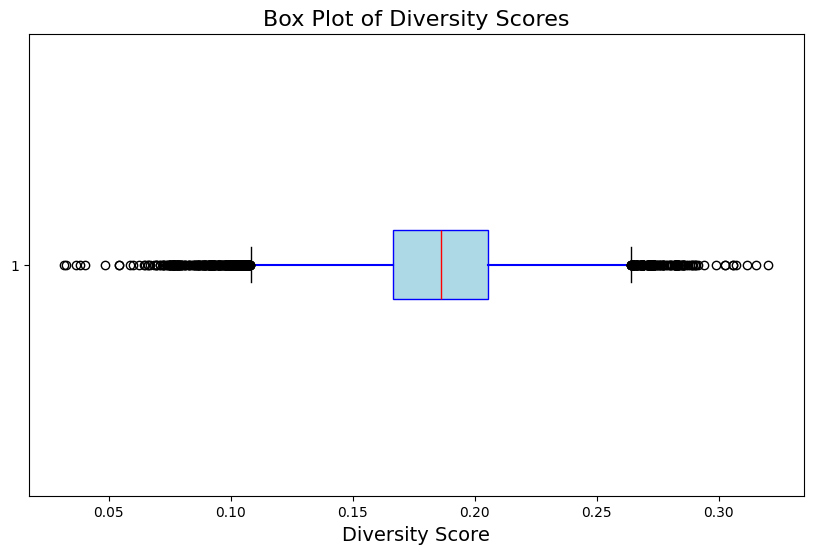

In [29]:
import matplotlib.pyplot as plt

def plot_diversity_boxplot(diversities):
    plt.figure(figsize=(10, 6))
    plt.boxplot(diversities, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue', linewidth=1.5), medianprops=dict(color='red'))
    plt.title('Box Plot of Diversity Scores', fontsize=16)
    plt.xlabel('Diversity Score', fontsize=14)
    plt.show()

# Example usage

plot_diversity_boxplot(diversities)


In [30]:
from collections import Counter

clicked_articles_test = df_test_behaviors['article_ids_clicked'].tolist()

# Ensure that IDs are strings (to match other data formats)
clicked_articles_test = [[str(article) for article in articles] for articles in clicked_articles_test]

# Count the frequency of articles in the training set
article_counts = Counter(df_train_behaviors['article_id'])
# Extract the Top-K most popular articles (e.g., Top-10)
baseline_articles = [article for article, _ in article_counts.most_common(10)]

# Ensure that IDs are strings
baseline_articles = [str(article) for article in baseline_articles]

# Convert clicked articles to integers
clicked_articles_test = [[int(article) for article in articles] for articles in clicked_articles_test]


In [31]:
def calculate_serendipity(recommendations, clicked_articles, baseline_articles):
    """
    Calculate the Serendipity Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        clicked_articles (list of list): Lists of article IDs clicked by each user.
        baseline_articles (list): List of popular article IDs used as a baseline.

    Returns:
        float: Average Serendipity Score across all users.
    """
    serendipities = []
    for rec_list, clicked in zip(recommendations, clicked_articles):
        # Unexpected recommendations: not in baseline
        unexpected = [article for article in rec_list if article not in baseline_articles]

        # Relevant unexpected recommendations: clicked by the user
        relevant = [article for article in unexpected if article in clicked]

        # Serendipity score for the user
        serendipity_score = len(relevant) / len(rec_list) if len(rec_list) > 0 else 0
        serendipities.append(serendipity_score)

    return serendipities
serendipities = calculate_serendipity(article_id_recommendations_test, clicked_articles_test, baseline_articles)
serendipity_score = np.mean(serendipities)
print(f"Serendipity Score: {serendipity_score:.4f}")

Serendipity Score: 0.1171


Serendipity measures the extent to which a recommendation system provides unexpected yet relevant recommendations to the user. It goes beyond accuracy by evaluating whether the recommendations surprise the user in a positive way.

A Serendipity Score of 0.1171 indicates that the system provides a small percentage of unexpected but relevant recommendations to the users.

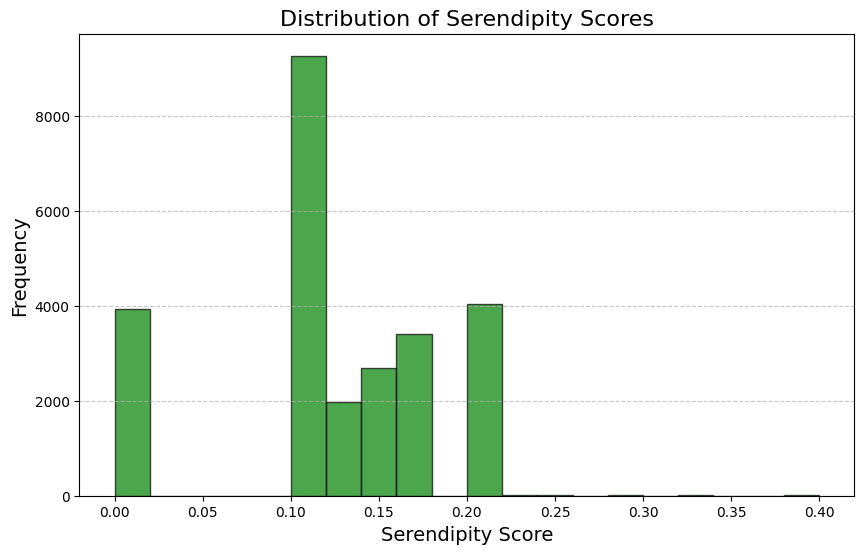

In [32]:
def plot_serendipity_histogram(serendipities):
    plt.figure(figsize=(10, 6))
    plt.hist(serendipities, bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Serendipity Scores', fontsize=16)
    plt.xlabel('Serendipity Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_serendipity_histogram(serendipities)


In [33]:
# Total number of articles in the training set
total_count = sum(article_counts.values())

# Create article_popularity dictionary
article_popularity = {article: count / total_count for article, count in article_counts.items()}

In [34]:
def calculate_novelty(recommendations, article_popularity):
    """
    Calculate the Novelty Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        article_popularity (dict): Dictionary mapping article IDs to popularity probabilities.

    Returns:
        float: Average Novelty Score across all users.
    """
    novelty_scores = []
    for rec_list in recommendations:
        novelty_sum = 0
        for article in rec_list:
            # Get the popularity of the article, default to a very small probability
            prob = article_popularity.get(article, 1e-6)
            novelty_sum += -np.log(prob)

        # Average novelty score for the user's recommendation list
        novelty_scores.append(novelty_sum / len(rec_list) if len(rec_list) > 0 else 0)

    return novelty_scores
novelty_scores = calculate_novelty(article_id_recommendations_test, article_popularity)
novelty_score = np.mean(novelty_scores)
print(f"Novelty Score: {novelty_score:.4f}")

Novelty Score: 13.8155


Novelty measures how "new" or "unfamiliar" the recommended items are to the user, often based on their global popularity:

Highly popular items are considered less novel because they are likely to be known by most users.
Less popular items are considered more novel because they have a higher likelihood of being new to the user.

A Novelty Score of 13.8155 indicates that the recommended articles are highly novel, meaning the system suggests articles that are generally less popular and not commonly seen by users.

In [36]:
total_articles = embedding_matrix.shape[0]


In [37]:
def calculate_item_coverage(recommendations, total_articles):
    """
    Calculate the Item Coverage for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        total_articles (int): Total number of articles available in the catalog.

    Returns:
        float: Coverage Score as a fraction of total articles covered.
    """
    # Unique articles recommended across all users
    recommended_articles = set(article for rec_list in recommendations for article in rec_list)

    # Coverage is the fraction of unique articles recommended
    return recommended_articles, len(recommended_articles) / total_articles
recommended_articles,_ = calculate_item_coverage(article_id_recommendations_test, total_articles)
_,coverage_score = calculate_item_coverage(article_id_recommendations_test, total_articles)
print(f"Item Coverage Score: {coverage_score:.4f}")

Item Coverage Score: 0.0206


Coverage evaluates how well the recommendation system utilizes the available content:

High Coverage: Suggests that the system explores a wide variety of articles.
Low Coverage: Indicates that the system focuses only on a limited set of articles, potentially overlooking many others.

An Item Coverage Score of 0.0206 indicates that the recommendation system utilizes only about 2% of the total articles in the catalog across all its recommendations. This suggests that the system focuses on a small subset of articles, likely the ones it deems most relevant for the users. However, this also highlights a limited exploration of the broader article catalog, potentially missing opportunities to diversify the recommendations.

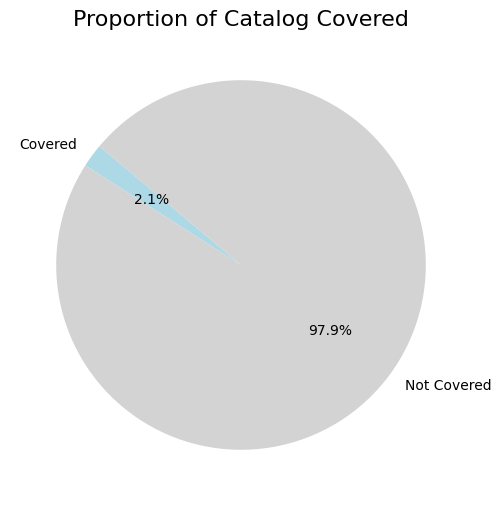

In [38]:
def plot_coverage_pie(recommended_articles, total_articles):
    coverage_score = len(recommended_articles) / total_articles
    plt.figure(figsize=(8, 6))
    plt.pie(
        [coverage_score, 1 - coverage_score],
        labels=["Covered", "Not Covered"],
        autopct="%1.1f%%",
        colors=["lightblue", "lightgrey"],
        startangle=140
    )
    plt.title("Proportion of Catalog Covered", fontsize=16)
    plt.show()

# Example usage
plot_coverage_pie(recommended_articles, total_articles)

In [3]:
print(f"Diversity Score: {diversity_score:.4f}")
print(f"Serendipity Score: {np.mean(serendipities):.4f}")
print(f"Novelty Score: {np.mean(novelty_scores):.4f}")
print(f"Item Coverage Score: {coverage_score:.4f}")
print(f"Unique recommended articles: {len(recommended_articles)}")
